## Demo fibooks by Timo Kats
Table of contents: 
* load data from excel
* valuation and basic computations
* combining different financial statements
* visualization
* machine learning
* income based valuation

_Note, the data used this demo is randomly generated._ 

In [1]:
# import fibooks libraries
from fibooks import balance_sheet
from fibooks import income_statement
from fibooks import statement_of_cashflows
from fibooks import other
# other libraries (that are integrated with fibooks)
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

#### Part 1: Loading data from excel
Since most financial statements are recorded in excel, fibooks is compatible with excel. Moreover, fibooks can import excel spreadsheets with loads of different structures and 'noise'. Which is something other libraries can't do. (PS: fibooks can also import from csv and pandas)  

![excel](https://github.com/TimoKats/medium_articles/blob/241d00a9e2cf8398894875954ad71d7c253f823c/img/excel.png?raw=true)  
_screenshots from the excel spreadsheet used in this demo_

In [3]:
company_c = balance_sheet('company c')
company_c.load_excel('data/balance_sheet_c.xlsx')
company_c.content

,cash,investments,inventories,accounts receivable,pre-paid expenses,other,property and equipment,leasehold improvements,equity and other investments,less accumulated depreciation,accounts payable,accrued wages,accrued compensation,income taxes payable,unearned revenue,total current liabilities,mortgage payable,investment capital,accumulated retained earnings
0,10.0,10.0,10.0,10.0,10.0,15.0,20.0,20.0,15.0,20.0,15.0,15.0,10.0,15.0,7.5,77.5,10.0,20.0,20.0
1,12.0,12.0,10.0,12.0,12.0,18.0,24.0,24.0,18.0,24.0,18.0,18.0,12.0,18.0,9.0,93.0,8.5,11.0,24.0


#### Part 2: Valuation and basic computations

The current ratio is included in fibooks by default. As are the catagories: _current assets_, _longterm assets_, _current liabilities_, _longterm liabilities_ and _equity_.

In [4]:
print("current assets for both years", company_c.get_total("current assets"))
print("current ratio for both years", company_c.current_ratio())

current assets for both years [65.0, 76.0]
current ratio for both years [0.43333333333333335, 0.43059490084985835]


However, if a user wants to compute a ratio that's not included in fibooks, the user can create custom categories and implement them in a valuation. In this example I'll demonstrate this with a quick ratio.

In [5]:
company_c.add_custom_category('cash & equivalents', ['cash', 'inventories', 'accounts receivable'])

print("cash & equivalents for both years", company_c.get_total("cash & equivalents"))
print("quick ratio for both years", company_c.custom_ratio('cash & equivalents', 'current liabilities'))

cash & equivalents for both years [30.0, 34.0]
quick ratio for both years [0.2, 0.19263456090651557]


#### Part 3: Combine different financial statements

In this part, I load two different income statements and combine them. This could be useful for companies that want to analyze high-level trends.

In [7]:
company_a = income_statement('company a')
company_b = income_statement('company b')

company_a.load_excel('data/income_statement_a.xlsx')
company_b.load_excel('data/income_statement_b.xlsx')

However, before we can combine two different income statements, the accounts need to match. In finance, similair names can refer to the same thing. For example, _COGS_ means the same as _cost of goods sold_ when mentioned in an income statement. As a result, we need to map account names

In [8]:
company_a.set_mapping({"cost of goods sold": "cogs"})

Now that the account names are the same, we can combine the two income statements into one giant data set

In [9]:
combined_dataset = other.combine_statements([company_a, company_b])
combined_dataset

revenue  discounts  net revenue  cogs  raw materials  \
company a 0       30         40           50    40             42   
          1       45         42           53    52             54   
          2       64         73           65    35             63   
          3       87         69           74    56             26   
company b 0       54          7            3    76             57   
          1        4         74           76    34             10   
          2       76          5           63    73             76   
          3       87         69           74    56             26   

             fulfillment  transaction fees  total cogs  labor  marketing  \
company a 0           25                23           6     25         54   
          1           36                62           6     64         62   
          2           42                45           5     64         72   
          3           53                26          76     23         73   
company b 0            3                 5          76     15         54   
          1            7                45          65     64         50   
          2           50                34          10     64         52   
          3           53                15          25     40         73   

             sga & other  total opex  depreciation & amortization  \
company a 0           40          52                           43   
          1           34          76                           23   
          2           63          65                           87   
          3           76          76                           63   
company b 0           54          63                           63   
          1           30          76                           17   
          2           63          65                           50   
          3           76          82                           63   

             interest expense  
company a 0                26  
          1                25  
          2                56  
          3                74  
company b 0                26  
          1                50  
          2                56  
          3                74

#### Part 4: Visualization

For this visualization, I want to show how the different accounts are correlated with one another. This is done for both income statements so this visual actually gives an aggregated view. 

<AxesSubplot:>

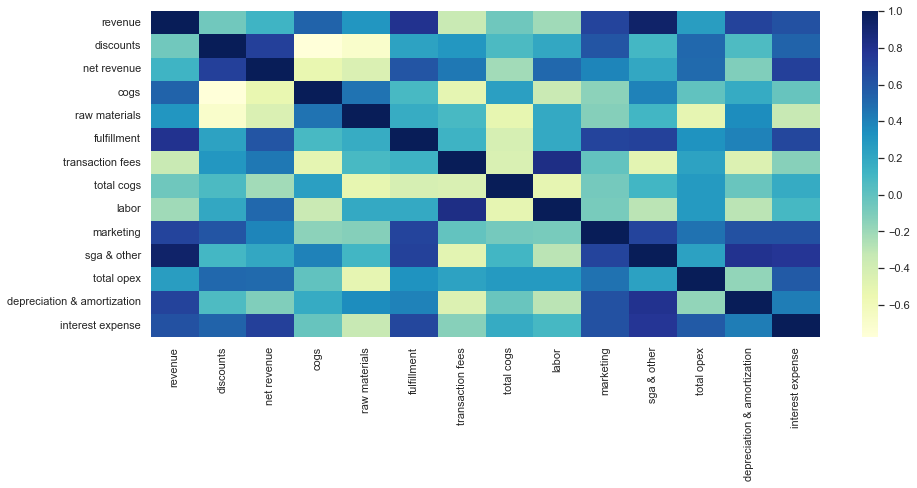

In [10]:
sns.set(rc = {'figure.figsize':(15,6)})
sns.heatmap(combined_dataset.corr(), cmap="YlGnBu")

#### Part 5: Machine learning

In this example, I'll use the data from fibooks to create a machine learning model. For this model, I'll add stockprices to our dataset (which fibooks supports). Next, the model will be trained to predict the stock price based on some fields from the income statements.  

In [12]:
combined_dataset.reset_index(drop=True, inplace=True)

stock_prices = pd.read_csv('data/stock_price.csv')
combined_dataset['stock prices'] = stock_prices['price']
X = combined_dataset[['labor', 'marketing', 'raw materials']]
y = combined_dataset[['stock prices']]

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)

After creating the model it can be visualized. Since this model is a decision tree, it can be presented in a tree-like format.

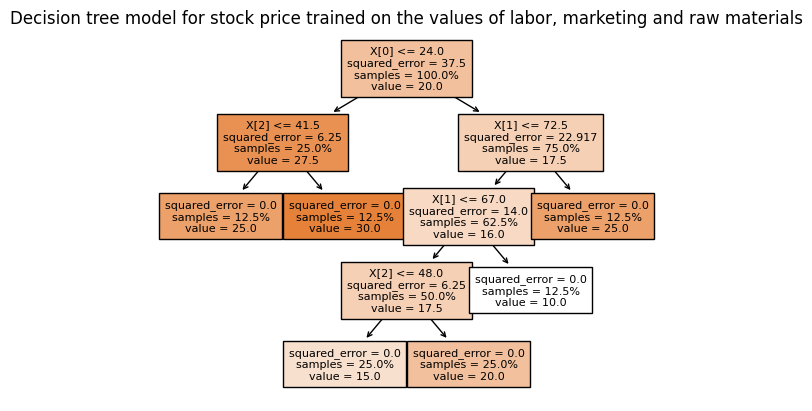

In [13]:
sns.reset_defaults()
tree.plot_tree(clf, filled=True, proportion=True, fontsize=8)
plt.title("Decision tree model for stock price trained on the values of labor, marketing and raw materials")
plt.show()

#### Part 6: Income based valuation method

In fibooks, users can automatically do valuation for companies. One of the valuation methods that can be used for this, is the _income based_ valuation method. 

In [14]:
company_d = statement_of_cashflows('company D')
company_d.load_excel('data/statement_of_cashflows_d.xlsx')

This method requires the user to know the amount of capital expenditures. Since this wasn't mentioned in the excel, this can be added manually.

In [15]:
company_d.add_account('capex', 15000)

Finally, the user can value the company with the income based valuation method.

In [16]:
other.income_based_valuation(company_d, r=0)

46450.0

![logo](https://github.com/TimoKats/medium_articles/blob/main/img/logo.png?raw=true)